**Local Statistics on Surfaces Using  District of Columbia Population Raster Dataset**

More and more spatial data are now available as surfaces, and figuring out how to compute local Moran’s I on them—rather than on geo-tables—is a more advanced topic in geographic data science. Since LISA for surfaces is still experimental and not as developed as for geo-tables, it’s a newer and evolving area. Next, we’ll dive in by using the District of Columbia population raster to explore its spatial patterns with Local Indicators of Spatial Association (LISAs).
- Population data source: https://hub.worldpop.org/geodata/summary?id=49727
- Reference: https://geographicdata.science/book/intro.html


In [29]:
# import matplotlib.pyplot as plt  # Graphics
# from matplotlib import colors
# import seaborn  # Graphics
# import geopandas  # Spatial data manipulation
# import pandas  # Tabular data manipulation
# import rioxarray  # Surface data manipulation
# import xarray  # Surface data manipulation
# from pysal.explore import esda  # Exploratory Spatial analytics
# from pysal.lib import weights  # Spatial weights
# import contextily  # Background tiles
# import numpy as np

In [2]:
# Open GeoTIFF file and read into `xarray.DataArray`
pop = rioxarray.open_rasterio("./DC_pop_2.tif")

In [3]:
pop.coords

Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -77.12 -77.12 -77.12 ... -76.91 -76.91 -76.91
  * y            (y) float64 39.0 38.99 38.99 38.99 ... 38.81 38.81 38.81 38.81
    spatial_ref  int32 0

In [4]:
pop.attrs

{'DataType': 'Generic',
 'AREA_OR_POINT': 'Area',
 'RepresentationType': 'ATHEMATIC',
 'STATISTICS_COUNT': 21067.0,
 'STATISTICS_COVARIANCES': 2074.965758743681,
 'STATISTICS_MAXIMUM': 1679.7327880859,
 'STATISTICS_MEAN': 29.992457612993,
 'STATISTICS_MEDIAN': 13.174375,
 'STATISTICS_MINIMUM': 0,
 'STATISTICS_SKIPFACTORX': 1,
 'STATISTICS_SKIPFACTORY': 1,
 'STATISTICS_STDDEV': 45.551792047555,
 '_FillValue': -99999.0,
 'scale_factor': 1.0,
 'add_offset': 0.0}

In [5]:
pop.shape

(1, 225, 254)

In [6]:
pop.sel(band=1)

<xarray.DataArray (y: 225, x: 254)>
[57150 values with dtype=float64]
Coordinates:
    band         int32 1
  * x            (x) float64 -77.12 -77.12 -77.12 ... -76.91 -76.91 -76.91
  * y            (y) float64 39.0 38.99 38.99 38.99 ... 38.81 38.81 38.81 38.81
    spatial_ref  int32 0
Attributes: (12/15)
    DataType:                Generic
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COUNT:        21067.0
    STATISTICS_COVARIANCES:  2074.965758743681
    STATISTICS_MAXIMUM:      1679.7327880859
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       45.551792047555
    _FillValue:              -99999.0
    scale_factor:            1.0
    add_offset:              0.0

In [7]:
# Read in the shapefile for Virginia counties
DC_boundary = geopandas.read_file(
    "./DC_boundary.json"
)

In [8]:
DC_boundary=DC_boundary[['NAME','geometry']]

In [9]:
DC_boundary = DC_boundary.to_crs(pop.rio.crs)


In [10]:
pop.rio.nodata

-99999.0

In [11]:
pop_clean = pop.where(pop != -99999.0)
band1_array = pop_clean[0].values

# Remove NaN values for statistical calculations
band1_array_no_nan = band1_array[~np.isnan(band1_array)]


print(f"Min: {band1_array_no_nan.min()}, Max: {band1_array_no_nan.max()}, Mean: {band1_array_no_nan.mean()}")


Min: 0.0, Max: 1679.7327880859375, Mean: 29.992457612993245


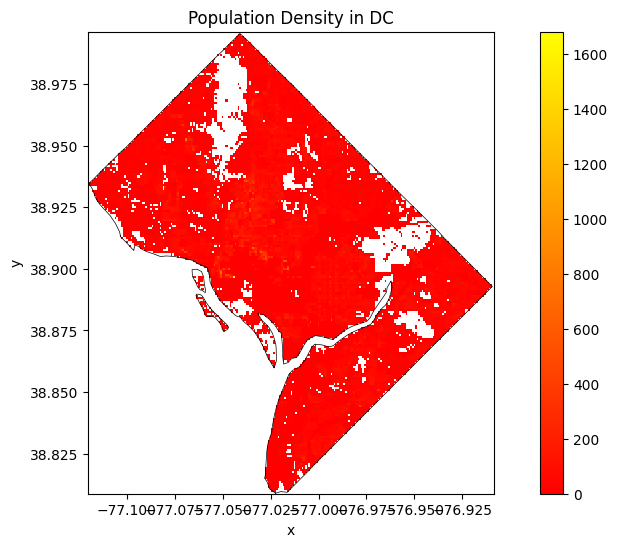

In [12]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the raster

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the raster
pop.where(pop != -99999.0).sel(band=1).plot(ax=ax, cmap="autumn",add_colorbar=True)

# Plot the polygon
DC_boundary.boundary.plot(ax=ax, edgecolor="Black", linewidth=0.5)

# Labels
ax.set_title("Population Density in DC")
plt.show()

In [13]:
# create a weights matrix to show how the pixels in the population data are connected
w_surface_sp = weights.Queen.from_xarray(pop)

In [14]:
w_surface_sp.sparse.dtype

dtype('int8')

In [15]:
type(w_surface_sp)

libpysal.weights.weights.WSP

To compute LISA, we need to make two changes to w_surface_sp. First, the matrix must use floats (numbers with decimals) to ensure accurate calculations. Second, we need a W object instead of the WSP we currently have. WSP objects are a simplified version of spatial weights matrices, optimized for certain calculations and using less memory. They work well for tasks like spatial econometrics. However, to compute LISA statistics, we need additional information, so we must convert WSP into a W object.

In [16]:
w_surface_all = weights.WSP2W(  
    weights.WSP(  
        w_surface_sp.sparse.astype(
            float
        ),  
        id_order=w_surface_sp.index.tolist() 
    )
)
w_surface_all.index = w_surface_sp.index

In [17]:
# Convert `DataArray` to a `pandas.Series`
pop_values = pop.to_series()
# Subset to keep only values that aren't missing
pop_values = pop_values[pop_values != pop.rio.nodata]

In [18]:
pop.rio.nodata

-99999.0

In [ ]:
w_surface = weights.w_subset(w_surface_all, pop_values.index)
w_surface.index = pop_values.index

In [ ]:
# calculate a LISA
pop_lisa = esda.moran.Moran_Local(
    pop_values.astype(float), w_surface, n_jobs=-1
)

In [21]:
from libpysal.weights import raster

Create a cluster plot to highlight statistically significant values using colors that match their quadrant in the Moran plot. To do this and then make a new Series that combines quadrant data with significance, using a 1% significance level.

In [22]:
sig_pop = pandas.Series(
    pop_lisa.q
    * (
        pop_lisa.p_sim < 0.01
    ),  # Quadrant of significant at 1% (0 otherwise)
    index=pop_values.index,  # Index from the Series and aligned with `w_surface`
)

Convert the sig_pop object which is a one-dimensional vector into a DataArray using the w2da function, which maps each value in sig_pop to its spatial arrangement based on w_surface.

In [23]:
# Build `DataArray` from a set of values and weights
lisa_da = raster.w2da(
    sig_pop,  # Values
    w_surface,  # Spatial weights
    attrs={
        "nodatavals": [pop.rio.nodata]
    }  # Value for missing data
    # Add CRS information in a compliant manner
).rio.write_crs(pop.rio.crs)

The new DataArray will have missing data pixels (matching the original population data), 0 for non-significant pixels, and values from 1 to 4 for significant clusters: HH, LH, LL, and HL—just like in the Brexit example.

In [24]:
lisa_da.to_series().unique()

array([-99999,      0,      3,      4,      2,      1])

create a colormap that matches the cluster colors with a matplotlib method that generates a color map from a list of colors.

In [25]:
from matplotlib.colors import ListedColormap

In [26]:
# LISA colors
lc = {
    "ns": "lightgrey",  # Values of 0
    "HH": "#d7191c",  # Values of 1
    "LH": "#abd9e9",  # Values of 2
    "LL": "#2c7bb6",  # Values of 3
    "HL": "#fdae61",  # Values of 4
}

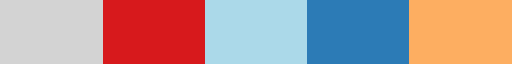

In [27]:
lisa_cmap = ListedColormap(
    [lc["ns"], lc["HH"], lc["LH"], lc["LL"], lc["HL"]]
)
lisa_cmap

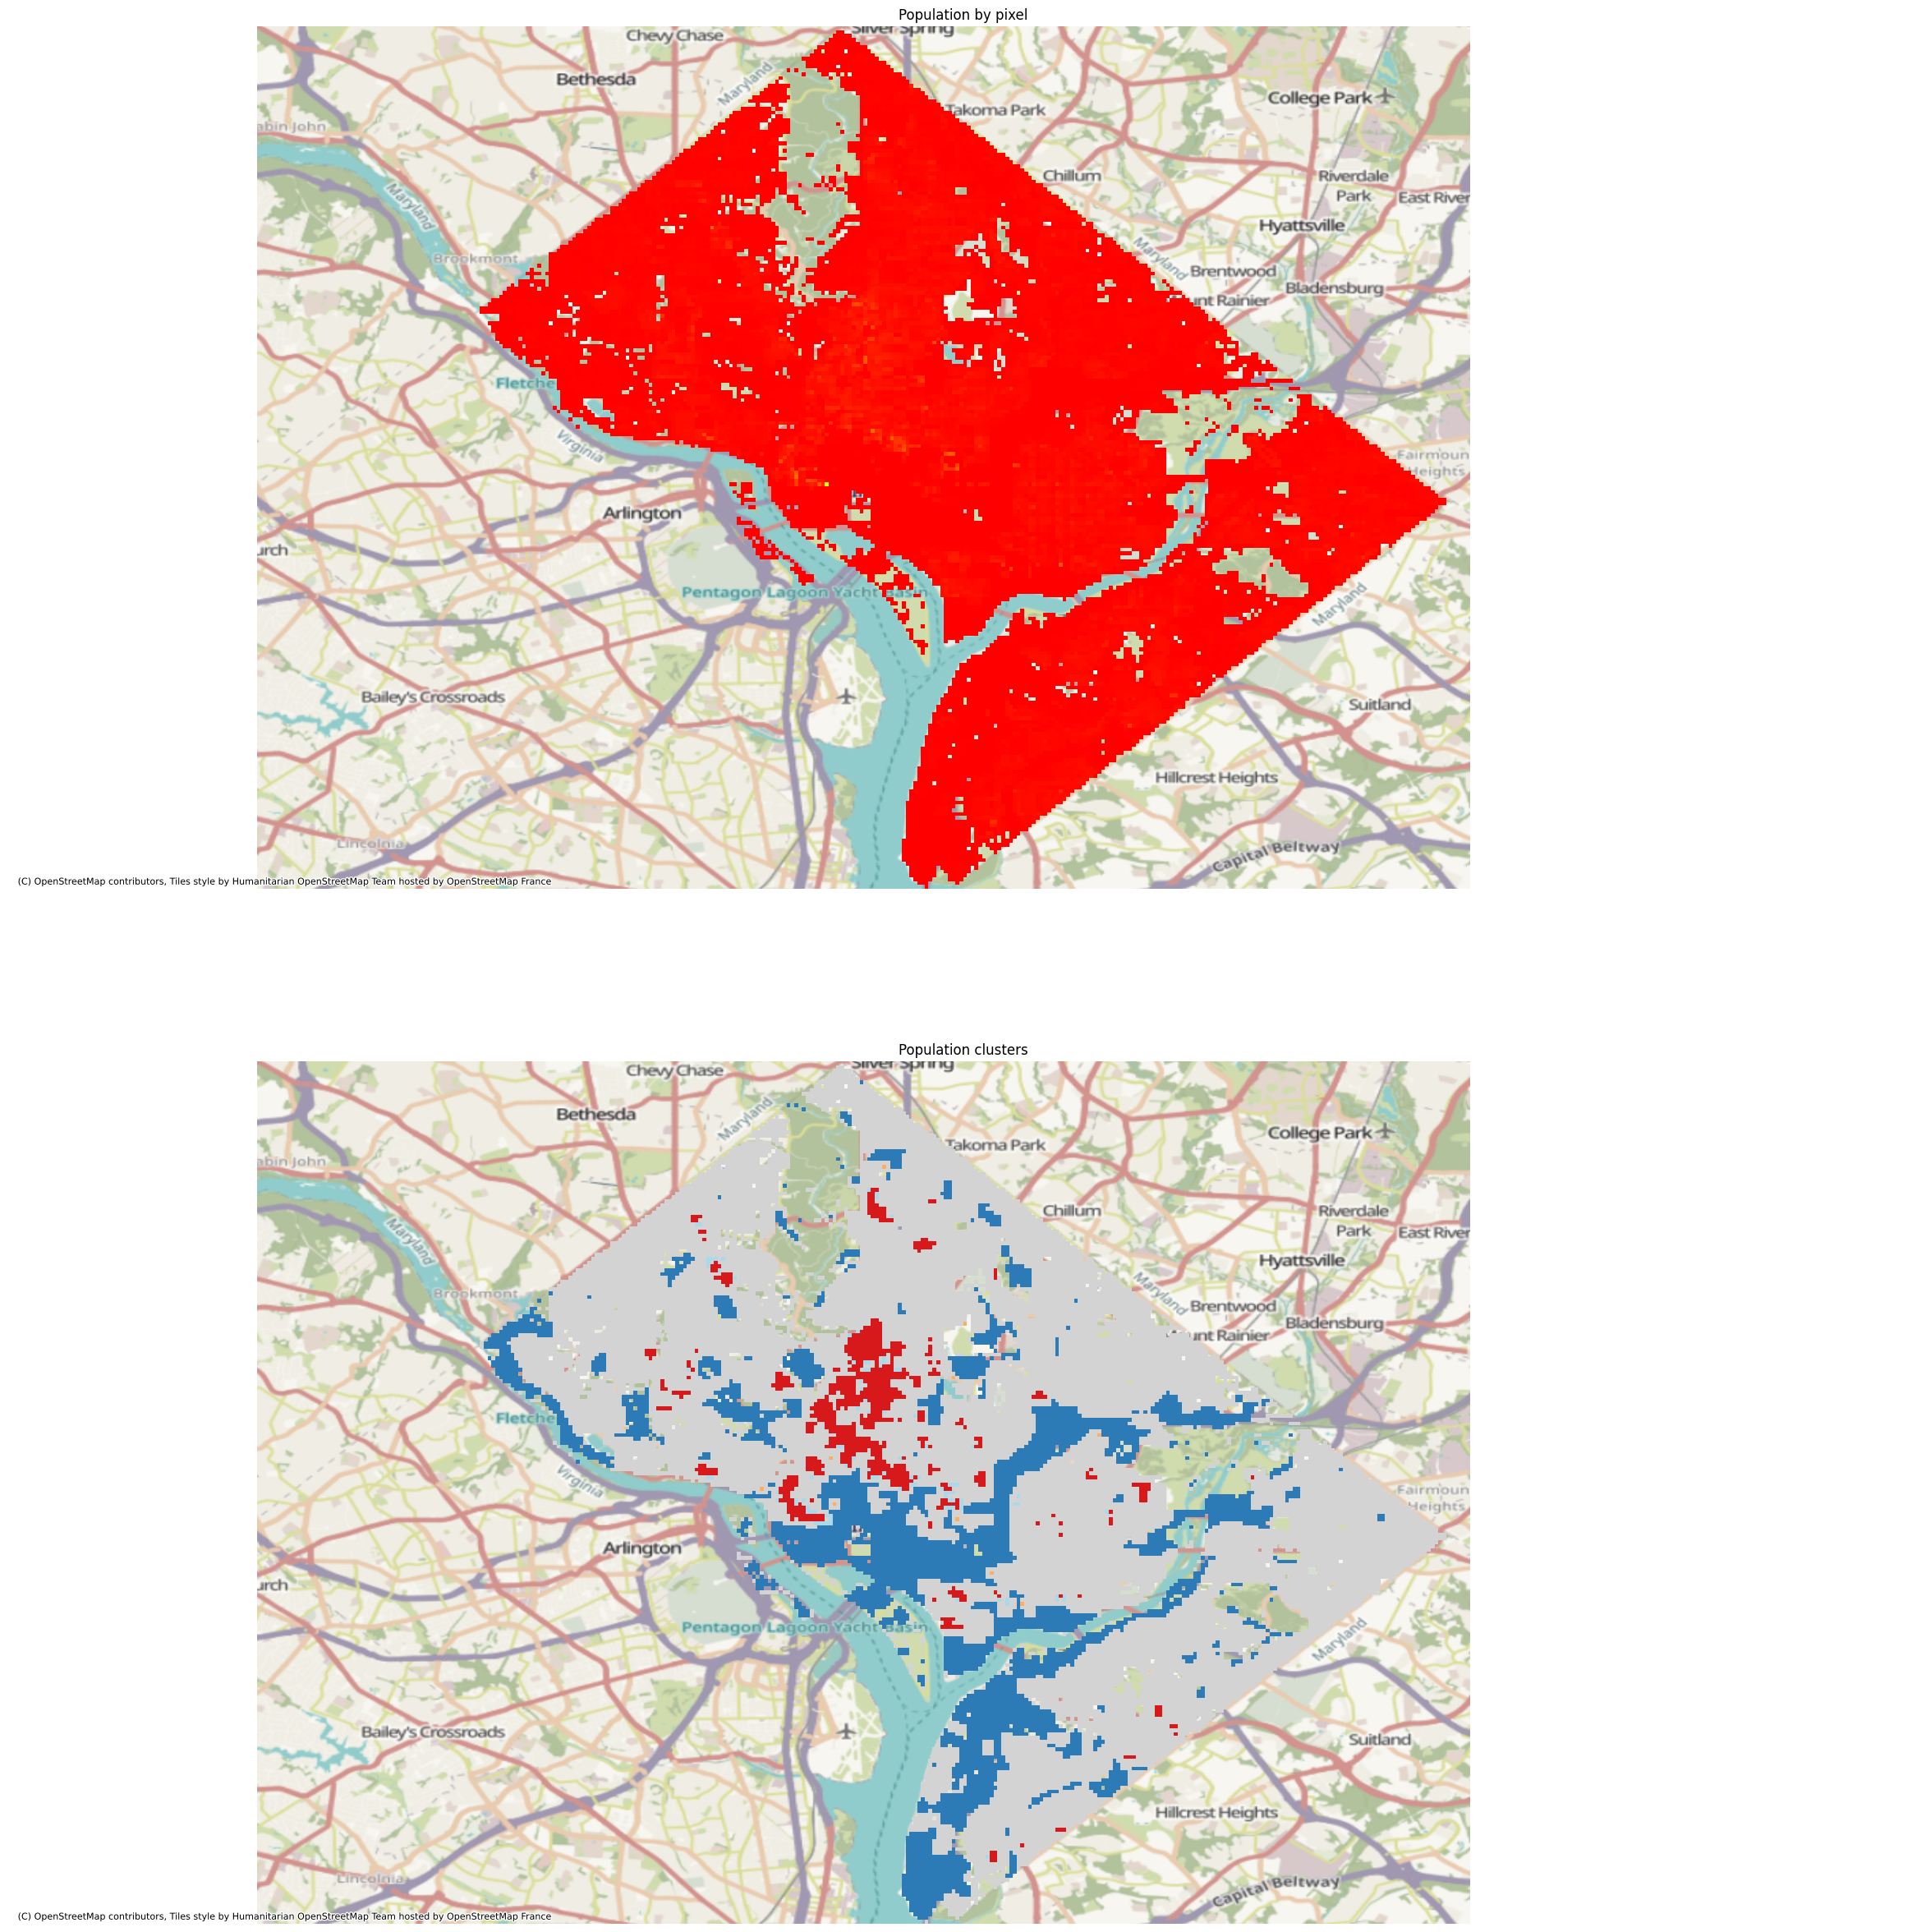

In [28]:
# Set up figure and axis
f, axs = plt.subplots(2, 1, figsize=(30, 30))
# Subplot 1 #
# Select pixels that do not have the `nodata` value
# (ie. they are not missing data)
pop.where(
    pop
    != pop.rio.nodata
    # Plot surface with a horizontal colorbar
).plot(
    cmap="autumn",
    ax=axs[0],   
    add_colorbar=False,  # , cbar_kwargs={"orientation": "horizontal"}
)
# Subplot 2 #
# Select pixels with no missing data and rescale to [0, 1] by
# dividing by 4 (maximum value in `lisa_da`)
(
    lisa_da.where(lisa_da != -99999.0)
    / 4
    # Plot surface without a colorbar
).plot(cmap=lisa_cmap, ax=axs[1], add_colorbar=False)
# Aesthetics #
# Subplot titles
titles = ["Population by pixel", "Population clusters"]
# Apply the following to each of the two subplots
for i in range(2):
    # Keep proportion of axes
    axs[i].axis("equal")
    # Remove axis
    axs[i].set_axis_off()
    # Add title
    axs[i].set_title(titles[i])
    # Add basemap
    contextily.add_basemap(axs[i], crs=lisa_da.rio.crs)

Local statistics are essential tools in geographic data science. When used correctly, they help analyze and visualize the patterns in geographic data. The Local Moran’s I statistic measures how observations relate to their nearby values. Mastering local statistics is crucial for any geographic data scientist, as they are often the first step in many analyses.